# Algorytmy Podziału Grafu

### Spis teści
1. Struktura
2. Algorytmy
    * Kernighana-Lina
    * Poziomujacy
    * Spektralny
    * Wielopoziomowy
3. Przykłady podziału na małych grafach
4. Przykłady podziału dużych grafów
5. Rysunki wygenerowane do pracy licencjackiej

## 1. Struktura

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from string import ascii_lowercase
%matplotlib inline

In [87]:
class Graph:
    letters = ascii_lowercase
    
    def __init__(self, data, nodes_starts_with_zero=True, positions=None, labels=None):
        t = 0 if nodes_starts_with_zero else 1
        
        if isinstance(data, str):
            with open(data) as file:
                self.n = int(file.__next__().split()[0])
                self.adj_mat = np.zeros((self.n, self.n))
                for i, line in enumerate(file):
                    line = line.split()
                    for v, w in zip(line[::2], line[1::2]):
                        self.adj_mat[i][int(v)-t] = int(w)
        else:
            self.adj_mat = data
            self.n = self.adj_mat.shape[0]
        
        self.nodes = np.arange(self.n)
        self.matched_nodes = {}
        self.partitions = None
        self.positions = positions
        self.labels = labels
    
    def partition_cost(self):
        if self.partitions is None:
            raise("Partitions are not set")
        return np.sum(self.adj_mat[np.ix_(self.partitions[0], self.partitions[1])]) 
    
    def save_graph_to_file(self, filename, nodes_starts_with_zero=True):
        """
            First Line contains n-verticles, m-edges, format: 3-digit number where 001 means weight graph
            set nodes_starts_with_zero=False to create output for MeTiS library
        """
        # 
        output = str(self.n) +" "+ str((self.adj_mat>0).sum()//2) + " 001\n"
        t = 0 if nodes_starts_with_zero else 1
        
        for i, row in enumerate(self.adj_mat):
            for j, weight in enumerate(row):
                if weight:
                    output += str(int(j)+t) +" "+ str(int(self.adj_mat[i][j])) + " "
            output = output.rstrip() + "\n"
            
            f = open(filename, "w")
            f.write(output)
            f.close()
            
    def print_graph(self, save_name=None, figsize=None):
        if figsize is not None:
            plt.figure(figsize=figsize)

        G = nx.Graph()
        G.add_nodes_from(self.nodes)
        for i in np.arange(self.n):
            for j in np.arange(i+1, self.n):
                if self.adj_mat[i][j]:
                    G.add_edge(i, j, weight=self.adj_mat[i][j])
    
        positions = self.positions if self.positions is not None else nx.spring_layout(G)
        nx.draw_networkx(G, positions, labels=self.labels)
        
        if self.partitions is None:
            nx.draw_networkx_nodes(G, positions, nodelist=self.nodes, node_color='cyan', with_labels=True)
        else:
            colors = ('cyan', 'yellow')
            for c, p in zip(colors, self.partitions):
                nx.draw_networkx_nodes(G, positions, nodelist=p, node_color=c, with_labels=True)

        edge_weights = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, positions, edge_labels=edge_weights)

        plt.axis('off')
        if save_name is not None:
            plt.savefig("img/"+save_name+".png")
        
        return plt.show()

## 2. Algorytmy

### Kernighan-Lin

In [3]:
def calc_D_values(v1, v2, adj_mat):
    D = np.zeros(adj_mat.shape[0])
    for node in np.union1d(v1, v2):
        sum1 = adj_mat[node, v1].sum()
        sum2 = adj_mat[node, v2].sum()
        ext_sum, int_sum = (sum2, sum1) if node in v1 else (sum1, sum2)
        D[node] = ext_sum - int_sum
    return D

def calc_g_values(v1, v2, adj_mat, D):
    a, b, max_gain = 0, 0, -np.inf
    
    for i, v in enumerate(v1):
        for j, u in enumerate(v2):
            t = D[v] + D[u] - 2*adj_mat[v, u]
            if t > max_gain:
                a, b, max_gain = i, j, t
                
    return a, b, max_gain 

def partition_cost(adj_mat, A, B):
    return np.sum(adj_mat[np.ix_(A, B)])
    
def kl_algo(graph, partitions=None, max_iter=-1):
    if partitions is None:
        nodes = np.array(list(graph.nodes))
        A, B = nodes[:graph.n//2], nodes[graph.n//2:]
    else:
        A,B = partitions[0], partitions[1]
    cost = partition_cost(graph.adj_mat, A, B)
    
    print("Initial partition cost: ", cost)
    iteration = max_iter if max_iter > 0 else -max_iter
    while iteration > 0:
        iteration-=1
        D = calc_D_values(A, B, graph.adj_mat)
        gain_seq, swaps_seq = [], []
        v1, v2 = A.copy(), B.copy()
        
        while(len(v1) and len(v2)):
            a, b, gain = calc_g_values(v1, v2, graph.adj_mat, D)
            
            v1a, v2b = v1[a], v2[b]
            gain_seq.append(gain)
            swaps_seq.append((v1a, v2b))

            v1, v2 = np.delete(v1, a), np.delete(v2, b)
            D[v1] += 2*graph.adj_mat[v1, v1a] - 2*graph.adj_mat[v1, v2b]
            D[v2] += 2*graph.adj_mat[v2, v2b] - 2*graph.adj_mat[v2, v1a]

    
        max_gain, current_sum, k = 0, 0, 0
        for j, gain in enumerate(gain_seq):
            current_sum += gain
            if current_sum > max_gain:
                max_gain, k = current_sum, j+1

        if max_gain > 0:
            swaps = np.array(swaps_seq)
            A = np.union1d(np.setdiff1d(A, swaps[:k, 0]), swaps[:k, 1])
            B = np.union1d(np.setdiff1d(B, swaps[:k, 1]), swaps[:k, 0])

            
            cost-=max_gain
            print("new partition cost: ", cost)
        else:
            break

    return A, B

### Poziomujący

In [26]:
def level_structure(graph, root, param_median_level=False, print_levels=True):
    verticles = np.arange(graph.n)
    not_visited, queue = np.array([1]*graph.n), []

    queue.append(root)
    not_visited[root] = 0
    levels, level_number = {0: [root]}, 1

    while queue:
        level_list, u = [], queue.pop(0)
        
        for i, v in enumerate(graph.adj_mat[u]):
            if v and not_visited[i]:
                level_list.append(i)
                queue.append(i)
                not_visited[i] = 0
        
        if level_list:
            levels[level_number] = level_list
            level_number += 1
            
    if print_levels:
        print("poziomy", levels)
    
    if param_median_level:
        return levels[int(np.median(np.arange(len(levels))))] 

    sep, sum_on_level = [], 0
    for lev in levels:
        sum_on_level += len(levels[lev])
        if sum_on_level > graph.n//2:
            sep = levels[lev]
            break

    return sep

### Spekrtalny

In [5]:
def find_smalest_positive(x):
    idx, smallest = 0, np.inf
    zero = np.isclose(x, np.zeros_like(x))
    
    for i, e in enumerate(x):            
        if not zero[i] and e < smallest:
            idx, smallest = i, e
            
    return idx
        

def spectral_bisection(graph):
    degree = np.diag([row.sum() for row in graph.adj_mat])
    lap = degree - graph.adj_mat
    
    e_val, e_vec = np.linalg.eig(lap)
    idx = find_smalest_positive(e_val)
    vector2 = e_vec[:, idx]
    median = np.median(vector2)
    
    A, B = [], []
    for i, e in enumerate(vector2):
        if e <= median:
            A.append(i)
        else:
            B.append(i)
    
    for i, e in enumerate(A):
        if len(A)-len(B) > 1:
            if vector2[e] == median:
                A.pop(i)
                B.append(e)
        else:
            break

    return A, B

### Wielopoziomowy

In [34]:
def coarseHEM(graph):
    new_adj_mat = graph.adj_mat.copy()
    nodes = np.arange(graph.n)
    graph_nodes, deleted, matched_nodes = [], [], {}
    
    ii=0
    while nodes.size:
        v1 = np.random.choice(nodes)
        nodes = nodes[nodes!=v1]
        v2, max_edge = -1, 0
        for n in nodes:
            if new_adj_mat[v1][n] > max_edge:
                v2, max_edge = n, new_adj_mat[v1][n]
        
        ii+=1
        matched_nodes[ii-1]=(v1,v2)
        if v2 < 0:
            continue
        nodes = nodes[nodes!=v2]
        
        new_adj_mat[v1, v2], new_adj_mat[v2, v1] = 0, 0
        for i in np.arange(graph.n):
            if new_adj_mat[v1, i] and new_adj_mat[v2, i]:
                new_adj_mat[v1, i] += new_adj_mat[v2, i]
                new_adj_mat[i, v1] = new_adj_mat[v1, i]
                new_adj_mat[v2, i], new_adj_mat[i, v2] = 0, 0
    
        new_adj_mat[v1] += new_adj_mat[v2]
        new_adj_mat[:, v1] += new_adj_mat[v2]
        new_adj_mat[v2], new_adj_mat[:, v2] = 0, 0
        deleted.append(v2)
    
    graph_nodes, k = {}, 0
    for i, row in enumerate(new_adj_mat):
        if row.sum():
            graph_nodes[k]=i
            k+=1

    new_adj_mat = np.delete(new_adj_mat, deleted, axis=1)
    new_adj_mat = np.delete(new_adj_mat, deleted, axis=0)
        
    g = Graph(new_adj_mat)
    g.matched_nodes = matched_nodes
    g.nodes = list(matched_nodes.keys())
    return g

In [7]:
def uncoarsening(graph, A, B):
    newA, newB = [], []
    for k, v in graph.matched_nodes.items():
        if v[1] >= 0:
            if k in A:
                newA.append(v[1])
            else:
                newB.append(v[1])
        if k in A:
            newA.append(v[0])
        else:
            newB.append(v[0])
    return newA, newB

def make_balance(adj_mat, A, B):
    bigger, smaller = (A, B) if len(A) > len(B) else (B, A)
    exchange = set()
    for s in smaller:
        min_edge = np.inf
        for k, b in enumerate(bigger):
            if adj_mat[s][b] and min_edge > adj_mat[s][b]:
                min_edge = adj_mat[s][b]
                exchange.add(b)
    
    for e in exchange:
        smaller.append(e)
        bigger.remove(e)
        if np.abs(len(bigger) - len(smaller)) <= 1:
            break
                
    return bigger, smaller 

In [8]:
def multi_level_algo(graph):
    coarse_graph = [graph]
    while True:
        new_graph = coarseHEM(coarse_graph[-1])
        coarse_graph.append(new_graph)
        if new_graph.n / coarse_graph[-2].n > 0.75 or new_graph.n==2:
            break
            
    last = coarse_graph[-1]
    A, B = spectral_bisection(last)
    A, B = uncoarsening(last, A, B)

    for g in coarse_graph[-2:0:-1]:
        if np.abs(len(A) - len(B)) > 1:  
            A, B = make_balance(g.adj_mat, A, B)
        A, B = kl_algo(g, (A,B), max_iter=1)
        A, B = uncoarsening(g, A, B)
    
    if np.abs(len(A) - len(B)) > 1:  
        A, B = make_balance(coarse_graph[0].adj_mat, A, B)
    return kl_algo(coarse_graph[0], (A,B))

## Przykłady podziału na małych grafach

**Przykład 1**

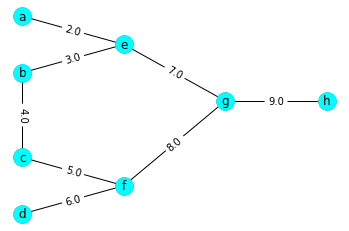

In [9]:
g8_pos = {0:(0,7), 1:(0,5), 2:(0,2), 3:(0,0), 4:(1,6), 5:(1,1), 6:(2,4), 7:(3,4)}
g8 = Graph(data="graphs/g8.txt", positions=g8_pos)
g8.labels = {i:Graph.letters[i] for i in np.arange(g8.n)}
g8.print_graph()

### Algorytmem Kerighan-Lin

Initial partition cost:  16.0
new partition cost:  11.0


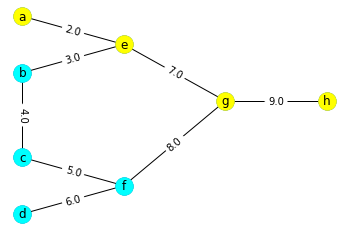

In [10]:
A, B = kl_algo(g8)
g8.partitions = A, B
g8.print_graph()

### Algorytm Pozomujący

**Separatory wierzchołków to wierzchołki znajdujące się na poziomie równym medianie**

poziomy {0: [7], 1: [6], 2: [4, 5], 3: [0, 1], 4: [2, 3]}


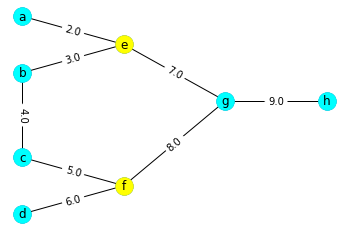

In [11]:
vertex_separator = level_structure(g8, 7, True)
A = set(g8.nodes) - set(vertex_separator)
B = vertex_separator

g8.partitions = A, B
g8.print_graph()

**Separatory wierzchołków to wierzchołki z j-tego poziomu takie, że suma wierzchołków na pierwszych j poziomach jest większa niż połowa wierzchołków w grafie**

poziomy {0: [7], 1: [6], 2: [4, 5], 3: [0, 1], 4: [2, 3]}


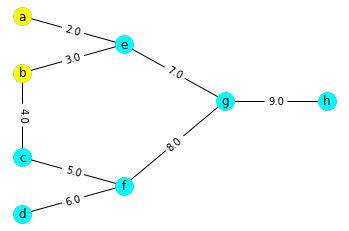

In [12]:
vertex_separator = level_structure(g8, 7, False)
A = set(g8.nodes) - set(vertex_separator)
B = vertex_separator

g8.partitions = A, B
g8.print_graph()

**Przykład 2**

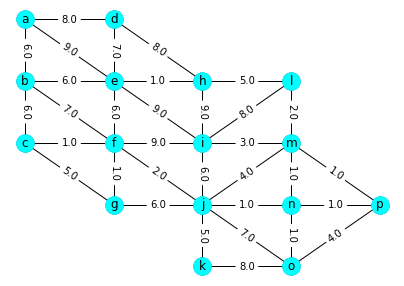

In [13]:
g16_pos = {
    0: (-1,8), 1: (-1,2), 2: (-1,-4), 3: (0,8), 4: (0,2), 
    5: (0,-4), 6: (0,-10), 7: (1,2), 8: (1,-4), 9: (1,-10),
    10: (1, -16), 11: (2,2), 12: (2, -4), 13: (2,-10), 
    14: (2,-16), 15:(3,-10)
}
g16 = Graph("graphs/g16.txt", positions=g16_pos)
g16.labels={i:Graph.letters[i] for i in np.arange(g16.n)}
g16.print_graph(figsize=(7,5))

## Algorytm Spektralny

koszt partycji A,B: 45.0


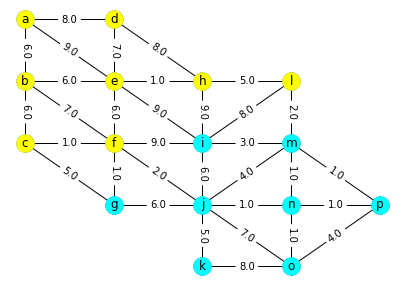

In [14]:
A, B = spectral_bisection(g16)
g16.partitions = A,B
print("koszt partycji A,B: {}".format(g16.partition_cost()))
g16.print_graph("spectral", figsize=(7,5))

## Algorytm Wielopoziomowy

Initial partition cost:  13.0
Initial partition cost:  22.0
Initial partition cost:  55.0
new partition cost:  21.0
Initial partition cost:  73.0
new partition cost:  21.0

koszt partycji A,B: 21.0


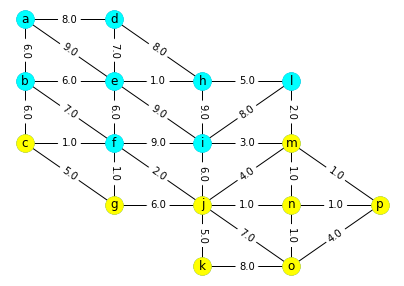

In [22]:
A, B = multi_level_algo(g16)
g16.partitions = A,B
print("\nkoszt partycji A,B: {}".format(g16.partition_cost()))
g16.print_graph(figsize=(7,5))

## Przykłady podziału dużych grafów

In [16]:
def create_undirect_graph_matrix(N, min_weight=0, max_weight=100):
    graph = np.zeros((N, N), int)
    losy = np.arange(min_weight, max_weight+1)
    
    for i in np.arange(N):
        for j in np.arange(i+1, N):
            weight = np.random.choice(losy, 1) 
            graph[j][i], graph[i][j] = weight, weight
    
    return graph

In [18]:
g5000 = Graph("graphs/g5000.txt", False)
# g5000 = Graph(create_undirect_graph_matrix(5000))

In [19]:
%%timeit -n 1 -r 1
A, B = spectral_bisection(g5000)
print(len(A), len(B))
print(partition_cost(g5000.adj_mat, A, B))

2500 2500
308414862.0
2min 44s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [20]:
%%timeit -n 1 -r 1
A, B = kl_algo(g5000, max_iter=1)
print(len(A), len(B))
print(partition_cost(g5000.adj_mat, A, B))

Initial partition cost:  309459470.0
new partition cost:  306183322.0
2500 2500
306183322.0
2h 34min 51s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [23]:
%%timeit -n 1 -r 1
A, B = multi_level_algo(g5000)
print(len(A), len(B))
print(partition_cost(g5000.adj_mat, A, B))

Initial partition cost:  297103672.0
new partition cost:  191547125.0
Initial partition cost:  297103672.0
new partition cost:  293885782.0
Initial partition cost:  308670449.0
new partition cost:  308522774.0
Initial partition cost:  308630936.0
new partition cost:  308492333.0
Initial partition cost:  308786339.0
new partition cost:  308457298.0
Initial partition cost:  308742058.0
new partition cost:  308353412.0
Initial partition cost:  308965708.0
new partition cost:  308406930.0
Initial partition cost:  308980949.0
new partition cost:  308272431.0
Initial partition cost:  309008463.0
new partition cost:  307976811.0
Initial partition cost:  309135333.0
new partition cost:  307604621.0
Initial partition cost:  309236963.0
new partition cost:  307069156.0
Initial partition cost:  309424576.0
new partition cost:  306150242.0
2500 2500
306150242.0
3h 1min 42s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Rysunki

## Rodzaje separatorów

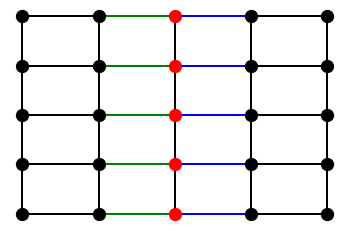

In [23]:
G = nx.Graph()
n = 5
nodes = np.arange(n*n)
G.add_nodes_from(nodes)
nodes = nodes.reshape(n, n)
pos = {nodes[i][j] : (i, j) for i in range(n) for j in range(n)}

ver_edges = {(i, j) for i in range(0, (n-1)*n+1, n) for j in range(i, i+n)}
hor_edges = {(j, j+n) for i in range(0, (n-1)*n, n) for j in range(i, i+n)}
edges = ver_edges | hor_edges

v_black = np.ravel(np.delete(nodes, 2, axis=0))
pos_v_black = {k:v for k,v in pos.items() if k in v_black}
nx.draw_networkx_nodes(G, pos_v_black, nodelist=v_black, node_color='k', node_size=150)

vS = nodes[2, :]
pos_vS = {k:v for k,v in pos.items() if k in vS}
nx.draw_networkx_nodes(G, pos_vS, nodelist=vS, node_color='r', node_size=150)

nx.draw_networkx_edges(G, pos, edgelist=edges, width=2, edge_color='k')
nx.draw_networkx_edges(G, pos, edgelist=[e for e in hor_edges if e[0] in vS], width=2, edge_color='b')
nx.draw_networkx_edges(G, pos, edgelist=[e for e in hor_edges if e[1] in vS], width=2, edge_color='g')


plt.axis('off')
# plt.savefig("img/separators.png")
plt.show()

## Skojarzenia w Grafie

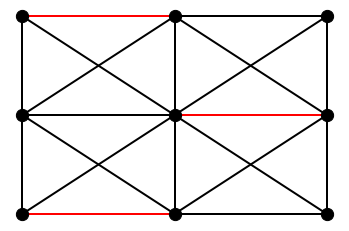

In [24]:
G = nx.Graph()
n = 3
nodes = np.arange(n*n)
G.add_nodes_from(nodes)
nodes = nodes.reshape(n, n)
pos = {nodes[i][j] : (i, j) for i in range(n) for j in range(n)}

ver_edges = {(i, j) for i in range(0, (n-1)*n+1, n) for j in range(i, i+n)}
hor_edges = {(j, j+n) for i in range(0, (n-1)*n, n) for j in range(i, i+n)}
skos_edges = {(0,4), (1, 3), (1, 5), (2, 4), (3, 7), (4,6), (4,8), (5, 7)} 
edges = ver_edges | hor_edges | skos_edges

v_black = np.ravel(nodes)
pos_v_black = {k:v for k,v in pos.items() if k in v_black}
nx.draw_networkx_nodes(G, pos_v_black, nodelist=v_black, node_color='k', node_size=150)


nx.draw_networkx_edges(G, pos, edgelist=edges, width=2, edge_color='k')

maximum_matching = [(0, 1), (2, 5), (3, 7), (4, 8)]
maximal_matching = [(0, 3), (4, 7), (2, 5)]
nx.draw_networkx_edges(G, pos, edgelist=maximal_matching, width=2, edge_color='r')


plt.axis('off')
# plt.savefig("img/maximum_matching.png") # edgelist=maximum_matching
# plt.savefig("img/maximal_matching.png") # edgelist=maximal_matching

plt.show()

## Algorytm wielo poziomowy - kroki

#### Faza Coarse

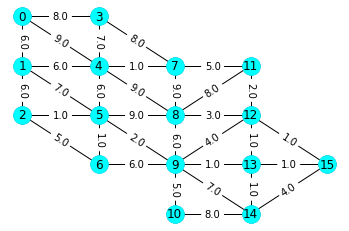

v1, v2  6 9
v1, v2  0 4
v1, v2  15 14
v1, v2  5 8
v1, v2  7 3
v1, v2  12 11
v1, v2  13 -1
v1, v2  10 -1
v1, v2  1 2
{0: (6, 9), 1: (0, 4), 2: (15, 14), 3: (5, 8), 4: (7, 3), 5: (12, 11), 6: (13, -1), 7: (10, -1), 8: (1, 2)}


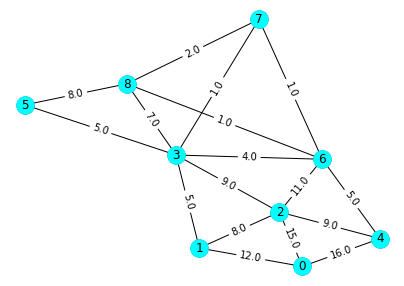

v1, v2  3 2
v1, v2  7 8
v1, v2  4 0
v1, v2  1 -1
v1, v2  6 -1
v1, v2  5 -1
{0: (3, 2), 1: (7, 8), 2: (4, 0), 3: (1, -1), 4: (6, -1), 5: (5, -1)}


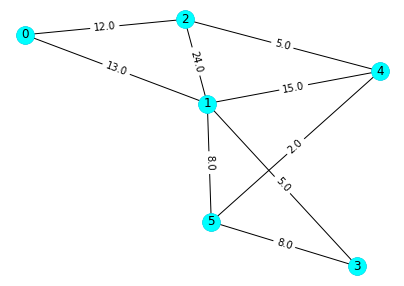

v1, v2  5 1
v1, v2  2 0
v1, v2  3 -1
v1, v2  4 -1
{0: (5, 1), 1: (2, 0), 2: (3, -1), 3: (4, -1)}


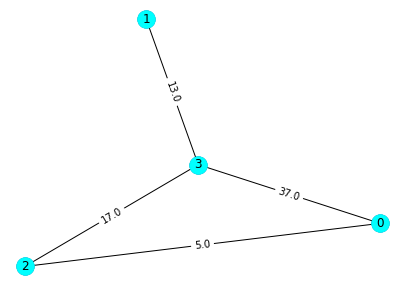

v1, v2  3 0
v1, v2  2 -1
v1, v2  1 -1
{0: (3, 0), 1: (2, -1), 2: (1, -1)}


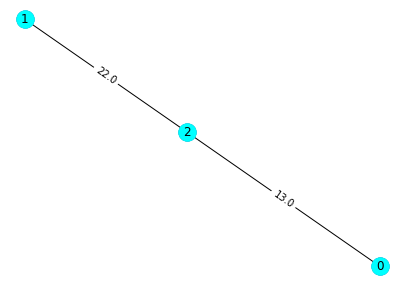

v1, v2  0 2
v1, v2  1 -1
{0: (0, 2), 1: (1, -1)}


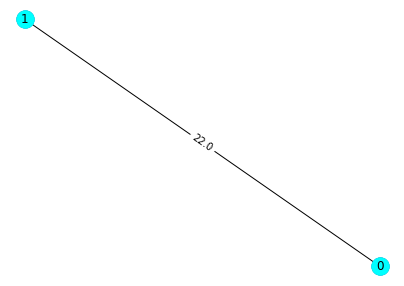

In [56]:
first = Graph(data="graphs/g16.txt", positions=g16_pos)
first.print_graph(figsize=(6,4))#, save_name="tmp/t/c0"

coarse_graph = [first]
ii=1
while True:
    new_graph = coarseHEM(coarse_graph[-1])
    coarse_graph.append(new_graph)
    print(new_graph.matched_nodes)
    new_graph.print_graph(figsize=(7,5))#, save_name="tmp/t/c"+str(ii) 
    ii+=1
    if new_graph.n / coarse_graph[-2].n > 0.75 or new_graph.n==2:
        break

#### Faza Uncoarse

{0: (0, 2), 1: (1, -1)}


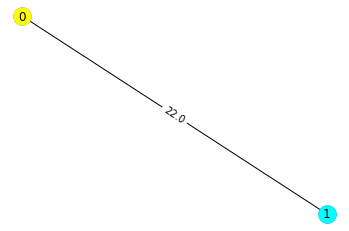

Initial partition cost:  22.0
new partition cost:  13.0
{0: (3, 0), 1: (2, -1), 2: (1, -1)}


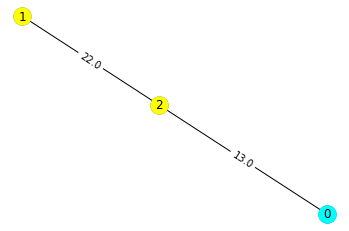

Initial partition cost:  35.0
{0: (5, 1), 1: (2, 0), 2: (3, -1), 3: (4, -1)}


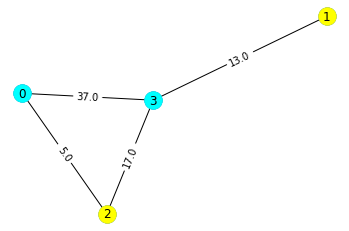

Initial partition cost:  55.0
new partition cost:  33.0
{0: (3, 2), 1: (7, 8), 2: (4, 0), 3: (1, -1), 4: (6, -1), 5: (5, -1)}


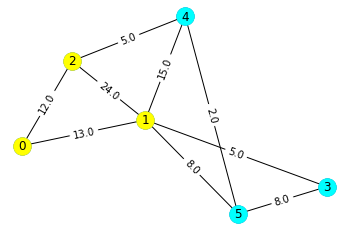

Initial partition cost:  60.0
new partition cost:  20.0
{0: (6, 9), 1: (0, 4), 2: (15, 14), 3: (5, 8), 4: (7, 3), 5: (12, 11), 6: (13, -1), 7: (10, -1), 8: (1, 2)}


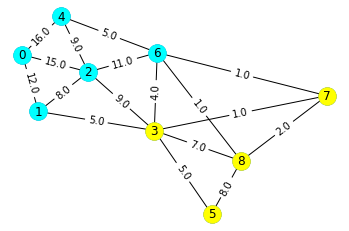

Initial partition cost:  70.0
new partition cost:  21.0


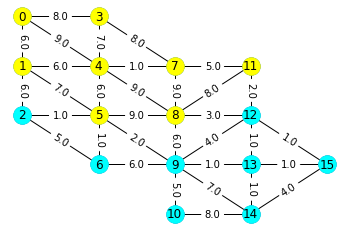

In [60]:
ii-=1
last = coarse_graph[-1]
A,B = spectral_bisection(last)
print(last.matched_nodes)
last.partitions = A,B
last.print_graph(figsize=(6,4))#, save_name="tmp/t/uc"+str(ii))

A, B = uncoarsening(last, A, B)
for graph in coarse_graph[-2:0:-1]:
    if np.abs(len(A) - len(B)) > 1:   
        A, B = make_balance(graph.adj_mat, A, B)
        
    A, B = kl_algo(graph, (A,B))
    print(graph.matched_nodes)
    
    graph.partitions = A,B
    graph.print_graph(figsize=(6,4))#, save_name="tmp/uc"+str(ii))
    ii-=1
    A, B = uncoarsening(graph, A, B)

    
if np.abs(len(A) - len(B)) > 1:  
    A, B = make_balance(first.adj_mat, A, B)
    
A, B = kl_algo(first, (A,B))
first.partitions = A,B
first.print_graph(figsize=(6,4))#, save_name="tmp/uc0")